In [27]:
from pathlib import Path
import pickle

import torch
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.patches as patches
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable

from datasets_utils import ds_load, ds_get_info

from push import find_high_activation_crop

import matplotlib.colors as mcolors

In [2]:
DATASETS_PATH = Path('datasets')
COLOR_CYCLE = ['#606060', '#AAAAAA', '#BBBBBB']

dataset, ds_info = ds_load(DATASETS_PATH, 'Libras', get_info=True)


Loading datasets:   0%|          | 0/1 [00:00<?, ?it/s]

In [79]:
def get_latest_model(exp_name):
    experiment_dir = Path(f'experiments/{exp_name}/').absolute()
    if os.path.isdir(experiment_dir / 'saved_models'):
        parent_dir = experiment_dir / 'saved_models'
        saved_models = [m for m in parent_dir.iterdir() if 'nopush' not in m.name]  # only get models after pushing
        saved_models = sorted(saved_models, key=lambda m: m.stat().st_mtime)
        return saved_models[-1]
    else:
        return experiment_dir / 'models' / 'last-epoch.pth'

def latest_epoch(exp_name):
    parent_dir = Path(f'experiments/{exp_name}/protos/')
    if not parent_dir.exists() or not any(parent_dir.iterdir()):
        return None
    latest_subdir = sorted(parent_dir.iterdir(), key=lambda d: d.stat().st_mtime)[-1]
    return latest_subdir.name.replace('epoch-', '')

def plot_single_feature(ax, y, rf_start, rf_end, color):
    x = range(len(y))
    
    if rf_start > 0:
        ax.plot(x[:rf_start+1], y[:rf_start+1], color=color)
    line, = ax.plot(x[rf_start:rf_end], y[rf_start:rf_end], color=color)
    if rf_end < len(y):
        ax.plot(x[rf_end-1:], y[rf_end-1:], color=color)
    return line

def visualize_proto(ts, proto_range, ax=None, proto_bg='#c1d1f077', y_lim=None, facecolor=None, title=None):
    if ax is None:
        _, ax = plt.subplots()
    lines = []
    labels = []

    rf_start = proto_range[0]
    rf_end = proto_range[1]

    default_color_cycle = COLOR_CYCLE
    for i, feat in enumerate(range(ts.shape[0])):
        lines.append(plot_single_feature(ax, ts[feat], rf_start, rf_end, color=default_color_cycle[i%len(default_color_cycle)]))
        labels.append(f'Feature {feat}')
    ax.set_xlim(0, ts.shape[1]-1)
    y_min_max = (np.min(ts[:, :-1]), np.max(ts[:, :-1]))
    y_range = y_min_max[1] - y_min_max[0]
    if y_lim is None:
        ax.set_ylim(y_min_max[0] - 0.2*y_range, y_min_max[1] + 0.2*y_range)
    else:
        ax.set_ylim(y_lim)
    y_lim = ax.get_ylim()
    ax.fill_between(range(rf_start, rf_end), *ax.get_ylim(), color=proto_bg) #, alpha=0.5)
    ax.set_ylim(y_lim)
    
    if facecolor is not None:
        ax.set_facecolor(facecolor)
    if title is not None:
        ax.set_title(title)

def visualize_matrix(matrix, figsize=None, show=True):
    if figsize is not None:
        plt.figure(figsize=figsize)
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')

    # Annotate the heatmap with the matrix values
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='white', fontsize=10)

    plt.xticks(range(matrix.shape[1]))
    plt.yticks(range(matrix.shape[0]))
    plt.gca().grid(False)
    plt.xlabel('Prototypes')
    plt.ylabel('Classes')

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="2%", pad=0.05)    
    plt.colorbar(cax=cax)

    if show:
        plt.show()

def calc_feature_importance(experiment_name):
    latest_model = get_latest_model(experiment_name)
    savedir = Path.cwd()
    try:
        os.chdir(Path(f'./experiments/{experiment_name}/').absolute())
        ppnet = torch.load(latest_model, map_location=torch.device('cpu'))
    finally:
        os.chdir(savedir)
    proto_features_importances = []
    for enc_out in range(len(ppnet.features.masks)):
        mask = ppnet.features.masks[enc_out]
        weights_for_enc_out = ppnet.add_on_layers[0].weight.data[:, enc_out, 0]
        product = np.multiply(np.array(mask).reshape((-1, 1)), weights_for_enc_out.numpy().reshape((1, -1)))
        proto_features_importances.append(product)

    feat_importance = np.abs(np.array(proto_features_importances).sum(axis=0)).sum(axis=1)
    return feat_importance / max(np.abs(feat_importance))

In [40]:
exp_name = 'LibrasTestExperiment'

In [62]:
latest_model = get_latest_model(exp_name)
savedir = Path.cwd()

experiment_dir = Path(f'experiments/{exp_name}/').absolute()
ptsnet = torch.load(latest_model, map_location=torch.device('cpu'))
ll_weight = ptsnet.last_layer.weight.to_dense().t() if ptsnet.last_layer.weight.is_sparse else ptsnet.last_layer.weight

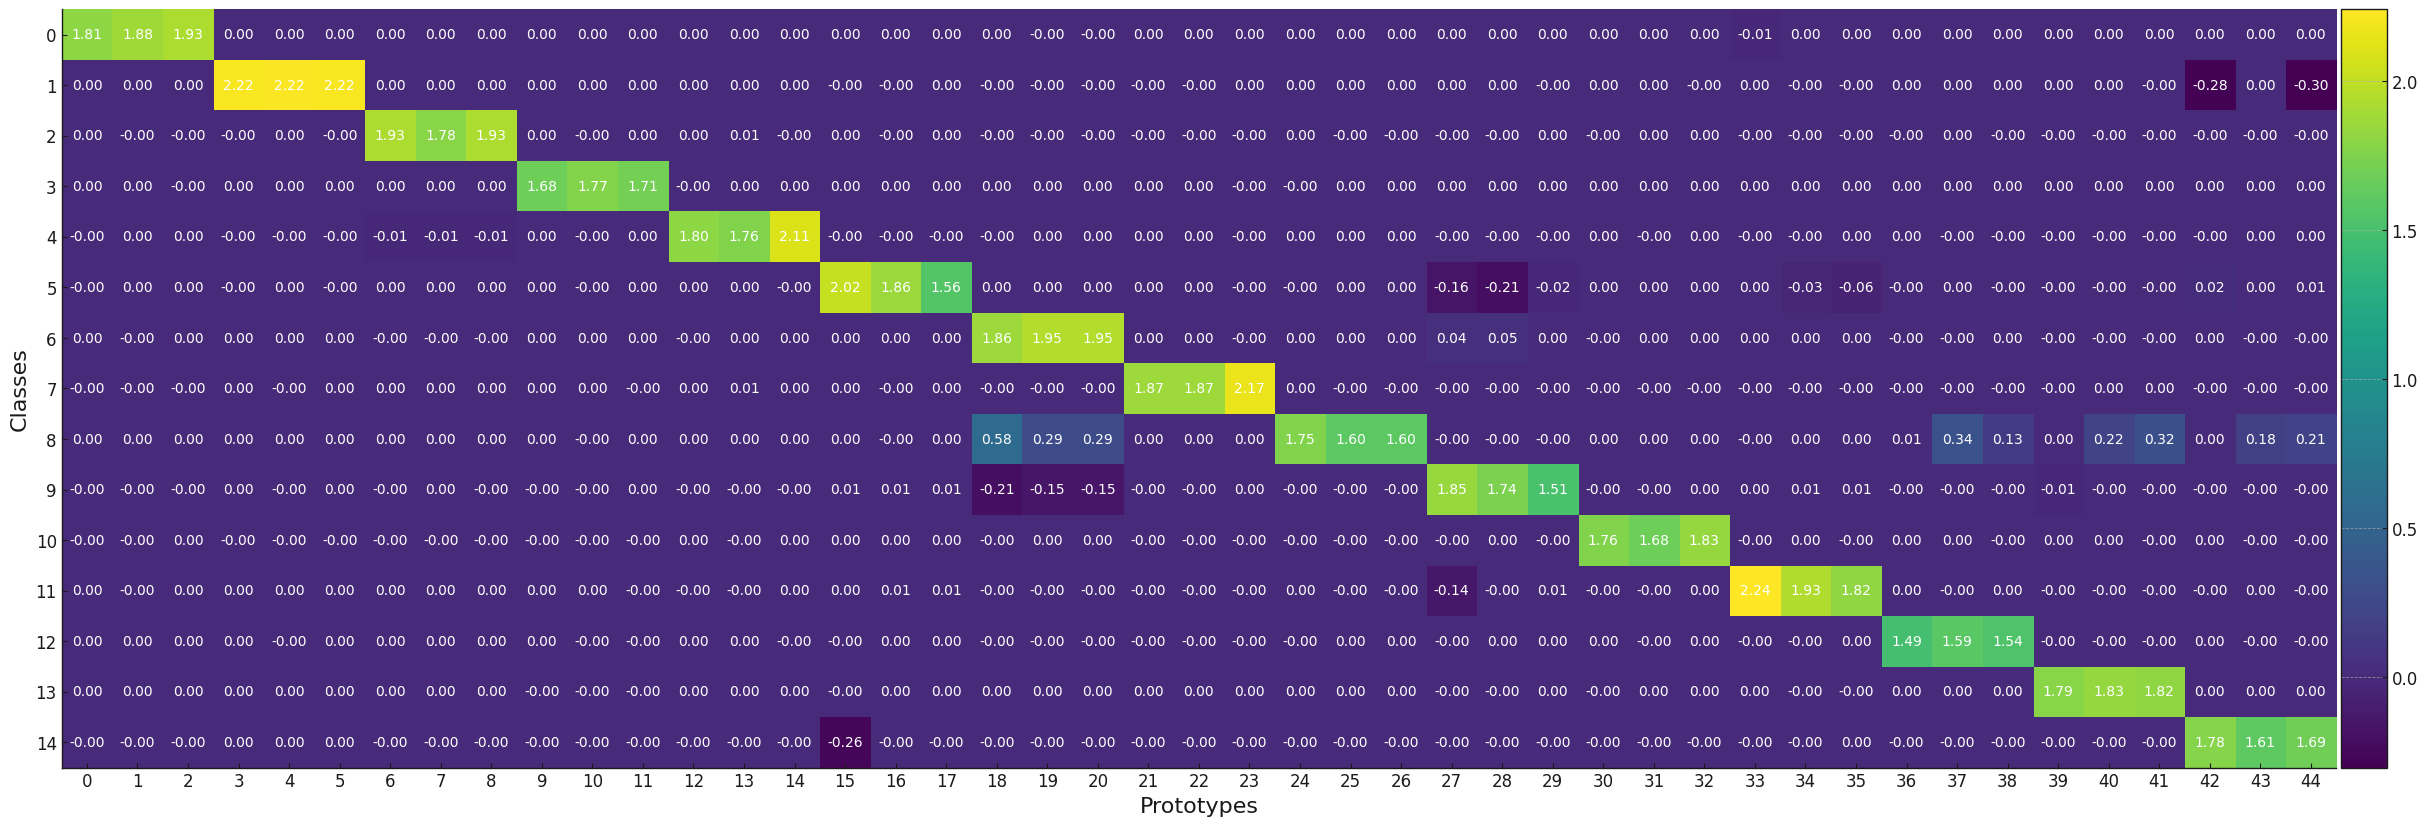

In [63]:
visualize_matrix(ll_weight.detach().numpy(), figsize=(30, 10))

0 (8, 8)
Predicted: 8
Actual: 8
Feature importance:
[1.        0.5306373]
Most activated 1 prototypes on this serie:
top 1 activated prototype on this serie:
prototype index: 24
prototype class identity: 8
activation value (similarity score): 1.713578701019287
last layer connection with predicted class: 1.7543668746948242
most highly activated patch of the chosen serie by this prototype:
(6, 24)


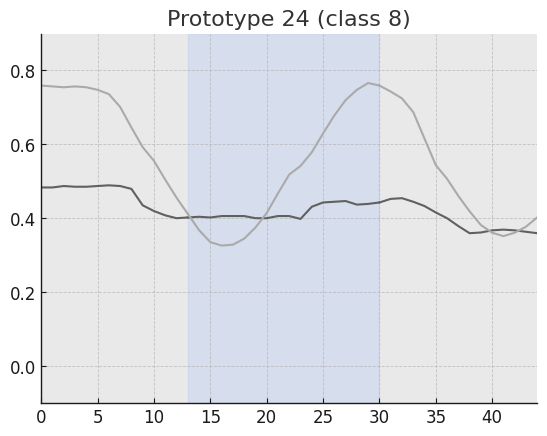

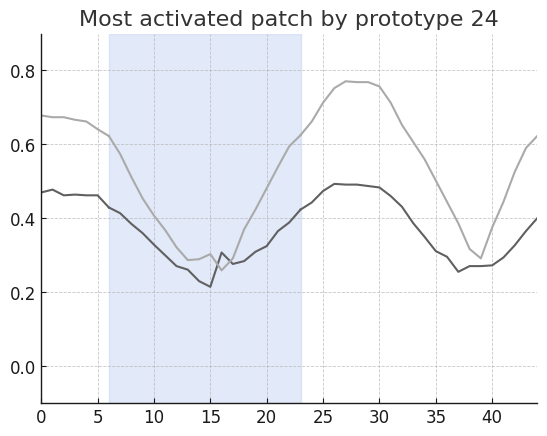

In [83]:
epoch_number_str = str(200)
ex_idx = 30
top_n_protos = 1

epoch_number_str = str(200)
prototype_info = np.load(os.path.join(Path(f'experiments/{exp_name}/protos').absolute(), 'epoch-'+epoch_number_str, 'bounds'+epoch_number_str+'.npy'))
prototype_img_identity = prototype_info[:, -1]

ex_npy = dataset.test.X[ex_idx]
ex = torch.tensor([ex_npy])
ex_label = dataset.test.y[ex_idx]

logits, min_distances = ptsnet(ex)
conv_output, distances = ptsnet.push_forward(ex)
prototype_activations = ptsnet.distance_2_similarity(min_distances)
prototype_activation_patterns = ptsnet.distance_2_similarity(distances)

tables = []
for i in range(logits.size(0)):
    tables.append((torch.argmax(logits, dim=1)[i].item(), ex_label))
    print(str(i) + ' ' + str(tables[-1]))

idx = 0
predicted_cls = tables[idx][0]
correct_cls = tables[idx][1]
print('Predicted: ' + str(predicted_cls))
print('Actual: ' + str(correct_cls))

print('Feature importance:')
print(calc_feature_importance(exp_name))

print(f'Most activated {top_n_protos} prototypes on this serie:')
array_act, sorted_indices_act = torch.sort(prototype_activations[idx])
for i in range(1, top_n_protos+1):
    print(f'top {i} activated prototype on this serie:')

    proto_ind = sorted_indices_act[-i].item()
    proto = np.load(f'experiments/{exp_name}/protos/epoch-{epoch_number_str}/prototype-ts-original_with_self_act{proto_ind:03d}.npy')
    receptive_field_size = 13 + ptsnet.prototype_shape[2] - 1
    rf_start, rf_end = find_high_activation_crop(proto[:, -1], proto_len=ptsnet.prototype_shape[2], ts_len=ex.shape[2])
    visualize_proto(proto[:, :-1].transpose(), (rf_start, rf_end), y_lim=(-0.1, 0.9), facecolor='#e9e9e9', title=f'Prototype {proto_ind} (class {prototype_img_identity[proto_ind]})')

    print('prototype index: {0}'.format(sorted_indices_act[-i].item()))
    print('prototype class identity: {0}'.format(prototype_img_identity[sorted_indices_act[-i].item()]))
    print('activation value (similarity score): {0}'.format(array_act[-i]))
    print('last layer connection with predicted class: {0}'.format(ptsnet.last_layer.weight[predicted_cls][sorted_indices_act[-i].item()]))
    
    activation_pattern = prototype_activation_patterns[idx][sorted_indices_act[-i].item()].detach().cpu().numpy()
    
    # show the most highly activated patch of the image by this prototype
    high_act_patch_indices = find_high_activation_crop(activation_pattern, proto_len=ptsnet.prototype_shape[2], ts_len=ex.shape[2])
    
    print('most highly activated patch of the chosen serie by this prototype:')
    print(high_act_patch_indices)
    visualize_proto(ex_npy, high_act_patch_indices, y_lim=(-0.1, 0.9), title=f'Most activated patch by prototype {proto_ind}')